In [1]:
import sys
import os
import cv2 as cv
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from CoffeeNet.dataset.dataset import CoffeeDataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Train images
train_images_names = os.listdir('../data/processed/images/train/')
# sort
train_mask_names = [image.split('.')[0]+"_mask.png" for image in train_images_names]
# Test images
test_images_names = os.listdir('../data/processed/images/test/')
# sort
test_mask_names = [image.split('.')[0]+"_mask.png" for image in test_images_names]

In [5]:
train_dataframe = pd.DataFrame({'images':train_images_names,'masks':train_mask_names})
test_dataframe = pd.DataFrame({'images':test_images_names,'masks':test_mask_names})

In [6]:
train_dataframe['images'] = train_dataframe['images'].apply(lambda x: os.path.join('../data/processed/images/train/',x))
train_dataframe['masks'] = train_dataframe['masks'].apply(lambda x: os.path.join('../data/processed/annotations/train/',x))

In [7]:
test_dataframe['images'] = test_dataframe['images'].apply(lambda x: os.path.join('../data/processed/images/test/',x))
test_dataframe['masks'] = test_dataframe['masks'].apply(lambda x: os.path.join('../data/processed/annotations/test/',x))

In [8]:
len(train_dataframe),len(test_dataframe)

(400, 50)

In [9]:
import json
with open('../data/external/annotations-info.json') as f:
    annotation_info = json.load(f)
annotation_info

{'background': [0, 0, 0], 'leaf': [0, 176, 0], 'symptom': [255, 0, 0]}

In [10]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((256,256))])

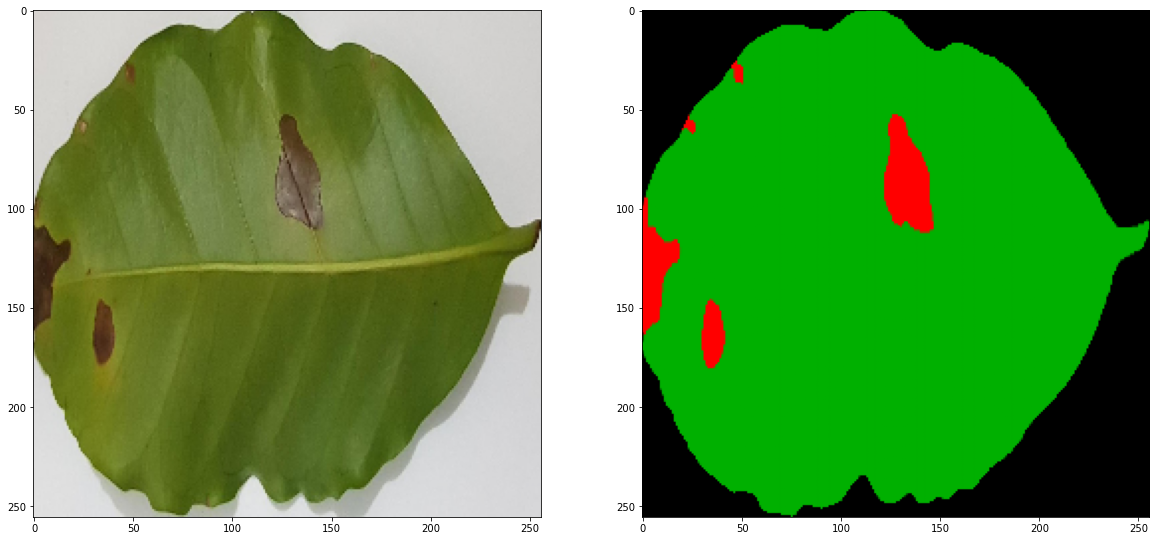

In [11]:
import random
img,mask = CoffeeDataset(train_dataframe,annotation_info,transform)[random.randint(0,len(train_dataframe)-1)]
fig,axs = plt.subplots(1,2,figsize=(20,50))
axs[0].imshow(img.permute(1,2,0))
axs[1].imshow(mask.permute(1,2,0),"gray")

# Start the training for one epoch

In [12]:
from models.train import train
import torch

In [13]:
# Define the data loader
from torch.utils.data import DataLoader
# Get the dataset
train_dataset = CoffeeDataset(train_dataframe,annotation_info,transform)
test_dataset = CoffeeDataset(test_dataframe,annotation_info,transform)
# Get the data loader
train_loader = DataLoader(train_dataset,batch_size=16)
test_loader = DataLoader(test_dataset,batch_size=16)

In [14]:
# Define the dice loss function
# define dice coefficient and dice loss function
def calc_dice_loss(preds:torch.Tensor,targets:torch.Tensor):
    def dice_coefficient(preds:torch.Tensor,targets:torch.Tensor):
        smooth = 1.0
        assert preds.size() == targets.size()
        
        iflat = preds.contiguous().view(-1)
        tflat = targets.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    return 1.0 - dice_coefficient(preds,targets)

In [15]:
# Define the unet model
from models.unet import UNet
unet_model = UNet(3,3)

In [16]:
# Define optimizer
import torch.nn as nn
import torch.optim as optim
opt = optim.Adam(unet_model.parameters(),lr=0.001)

In [17]:
print(train.__doc__)

 A Function to train a model
        returns -> trained model

        `Parameters`
        ----------
        `model`: torch model
        `criterion`: The loss function
        `opt`: Gradient optimization function of type 'torch.optim.'
        `train_loader`: torch DataLoader instance for the training data
        `test_loader`: torch DataLoader instance for the testing data
        `num_epoch`: The number of epoch for training

    


In [18]:
# Define the device
device = torch.device("mps")

In [19]:
# Train the model for 5 epochs
trained_mode,history = train(model=unet_model,criterion=calc_dice_loss,opt=opt,train_loader=train_loader,
test_loader=test_loader,train_data_len=len(train_dataset),test_data_len=len(test_dataset),batch_size=16,device=device,num_epoch=5)

Evaluation: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it, avg_dice_val_loss=0.938, avg_loss=0.938, avg_val_dice_coeff=0.0617]


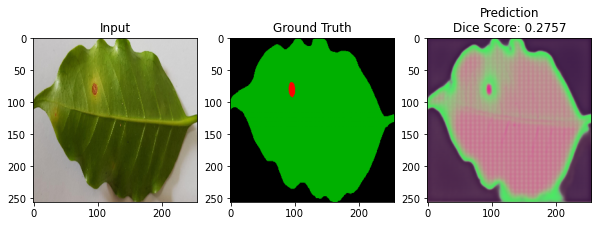

In [28]:
trained_mode.eval()
image,mask = CoffeeDataset(test_dataframe,annotation_info,transform)[random.randint(0,len(test_dataframe)-1)]
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
with torch.no_grad():
    image = image.to(device)
    mask = mask.to(device)
    pred = trained_mode(image)
    dice_loss = calc_dice_loss(pred,mask)
    image = image.squeeze(0)
    mask = mask.squeeze(0)
    pred = pred.squeeze(0)
    # Give the figure a title and axis labels
    fig,axs = plt.subplots(1,3,figsize=(10,10))
    axs[0].imshow(image.cpu().permute(1,2,0),cmap="gray")
    axs[0].set_title("Input")
    axs[1].imshow(mask.cpu().permute(1,2,0),cmap="gray")
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred.cpu().permute(1,2,0),cmap="gray")
    axs[2].set_title(f"Prediction\nDice Score: {round(1-dice_loss.data.item(),4)}")